# GAN Tutorial

- Implementation of GAN from :
    - https://arxiv.org/abs/1406.2661
    - https://arxiv.org/abs/1511.06434
- Reference codes :
    - https://docs.pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    - https://github.com/eriklindernoren/PyTorch-GAN

## DCGAN?

For better performance, this tutorial implements DCGAN instead of Vanilla GAN

- Uses CNN for Generator and Discriminator (Not MLP)
    - Generator : latent vector --> ConvUpsampling --> Image Generation
    - Discriminator : Generated Image --> ConvDownsampling --> Probability value
- Basically same with vanilla GAN

---

### Architecture Guides for Stable DCGAN

- Replace pooling layers with strided convolutions($D$) and fractional-strided convolutions($G$)
- Use batchnorm in both the $D$ and the $G$
- Remove fully connected hidden layers for deeper architectures
- Use ReLU in $G$ for all layers except for the output, which uses $\tanh$
- Use LeakyReLU in the $D$ for all layers

---

### What do we need?

- Dataset : CelebA
- CNN structure
- Discriminator
- Generator
- Loss function

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import DataLoader
import numpy as np

In [89]:
import random

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


## Model Hyperparameters

Basic Parameters

- Device : CPU / GPU ?
- Batch Size $B$
- Learning rate / Epochs
- Vector Dimensions
    - Latent dim($G$ input)
    -0 

CNN parameters

- Image $(B \times C \times W \times H )$
    - Size : $W \times H$
    - Channels $C$ ; Usually $3$ for RGB
- Filters

In [90]:
dataset_path = "~/datasets/CelebA"
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
epochs = 5
lr = 0.0002
latent_dim = 100

# Conv paprameters
image_size = 64 # W * H --> 64 * 64
channels = 3
filters = 64

## Data Preparation

### Celeb-A Faces dataset
Liu, Z., et al, "Deep Learning Face Attributes in the Wild," \
in Proceedings of International Conference on Computer Vision (ICCV), 2015.

- 10,177 number of identities
- 202,599 number of face images, and
- 5 landmark locations, 40 binary attributes annotations per image

According to tutorials ...

- We use only the face dataset for training
- Download the dataset 
    - https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
    - `img_align_celeba.zip` ; 1.3GB
- `mkdir` CelebA and extract zip file to the directory
- directory should be like below :

```bash
~/datasets/Celeba
    -> img_align_celeba
        -> 188242.jpg
        -> 173822.jpg
        -> 284702.jpg
        -> 537394.jpg
           ...
```

In [91]:
import os

p=os.path.expanduser("~/datasets/CelebA/img_align_celebA") 
print("exists" if os.path.isdir(p) else "NOT FOUND")
if not any(os.scandir(p)):
    print(p, "EMPTY")
else:
    n = sum(1 for _ in os.scandir(p))
    print(p, n, ", NOT_EMPTY")

exists
C:\Users\evana/datasets/CelebA/img_align_celebA 202599 , NOT_EMPTY


### Why making subdirectory `~/CelebA/img_align_celebA`?

- We use `ImageFolder` class in `torchvision.datasets as dataset`
- `ImageFolder` class
    - Requires subdirectories in root folder(`CelebA`)
    - Actual Work : Returns `(Image_tensor, label)`, subdirectory is used as labels
    - We don't need the label, but anyway the class needs --> Make Subdirectory
    - Can use `torchvision.transforms`

In [92]:
dataset = datasets.ImageFolder(root = dataset_path,
                               transform = transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   # Normalizing valuse in each RGB Channels by 0 ~ 1 to -1 ~ +1
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ]))

kwargs = {'num_workers' : 2, 'pin_memory' : True}

# DataLoader 
dataloader = DataLoader(dataset, batch_size, shuffle = True, **kwargs)

### `transforms.Resize()`

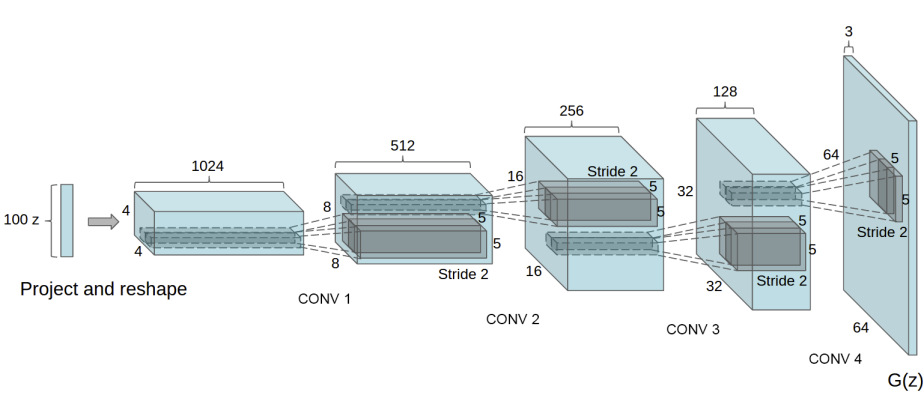
- Actual DCGAN Architecture Requires the image to be 64 * 64 size
- CelebA Face data : 178 * 218
- Resize the data !

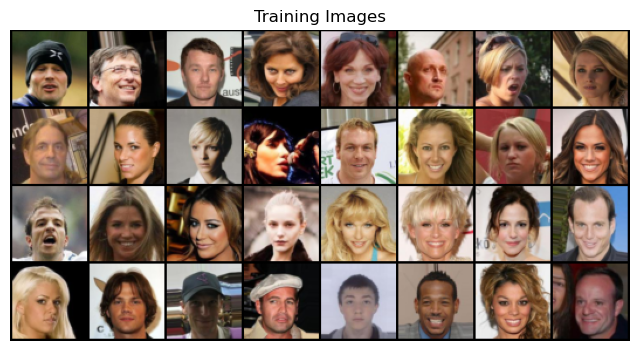

In [93]:
# Check some data in dataset

import matplotlib.pyplot as plt
import matplotlib.animation as animation

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(Device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## DCGAN Implemetation

### Weight Initialization

Check "4. DETAILS OF ADVERSARIAL TRAINING" in paper !

> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

- Weights are in `nn.Conv` and `nn.BatchNorm`
- $\mu = 0$
- $\sigma = 0.02$
- Note that BatchNorm parameters $\gamma, \beta$ are excluded in the paper's 'weights' 
    - Using 0.02 is usual anyway...

### How to customize the initialization of the weights?

- Use `nn.init.xxx()` !
    - uniform_
    - normal_
    - etc...
    - Initialize the weight tensor by using the input value
- https://docs.pytorch.org/docs/stable/nn.init.html


In [94]:
import argparse

def weights_init(m):
    # m = torch __class__  = nn
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.002)
    elif classname.find("BatchNorm") != -1:
        # gamma --> 1.0 with std 0.02, (1.0, 0.0) is default
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        # beta --> 0 is default
        nn.init.constant_(m.bias.data, 0)

### Generator Impelemtation

Generator gradually converts $\mathbf z \in \mathbb R^{100}$ to $\boldsymbol X' = G(\mathbf z) \in \mathbb R^{64\times 64}$.\
Actual process is reverse of usual CNN structure.\
\
Check the image again !

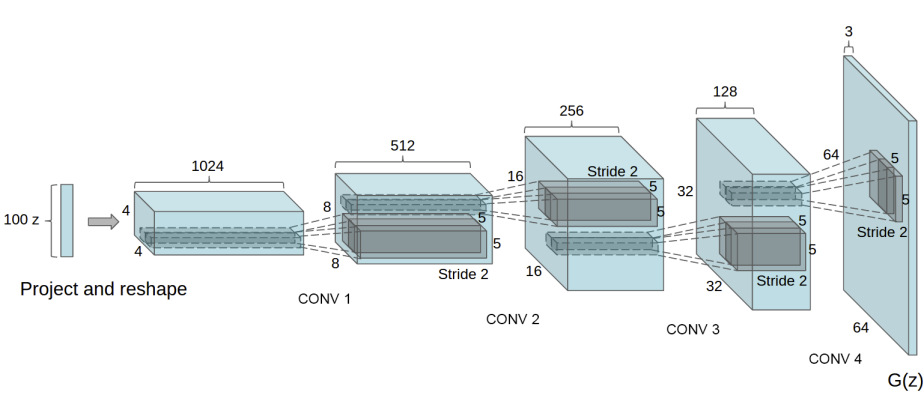\

__! Note !__
- Actual hyperparameters of image are not used
- We use `kernel_size = 4`, not `5`


For Upsampling(deconvolution), use `nn.ConvTranspose2D` !
- in_channels 
- out_channels 
- kernel_size 
- stride=1, 
- padding=0,


Consider $\mathbf z$ as 100 - channeled data, not a vector.

---

__Tip for calculating size of output__

$O = \displaystyle \frac{W-F+2P}{S} + 1$

---

__Actual Deconvolution Flow__

- Conv0 : $(B \times 1 \times 1 \times 100) \rightarrow (B \times 4 \times 4 \times 1024)$
- Conv1 : $(B \times 4 \times 4 \times 1024) \rightarrow (B \times 8 \times 8 \times 512)$
- Conv2 : $(B \times 8 \times 8 \times 512) \rightarrow (B \times 16 \times 16 \times 256)$ 
- Conv3 : $(B \times 16 \times 16 \times 256) \rightarrow (B \times 32 \times 32 \times 128)$ 
- Conv4 : $(B \times 32 \times 32 \times 128) \rightarrow (B \times 64 \times 64 \times 3)$ 

In [95]:
# set working gpu, ngpu = 0 if CPU mode
ngpu = 1

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Projection and Reshape : Conv0
            nn.ConvTranspose2d(latent_dim, filters*16, 4, 1, 0, bias = False),
            nn.BatchNorm2d(filters*16),
            nn.ReLU(True), # True --> inplace = True
            #Conv1
            nn.ConvTranspose2d(filters*16, filters*8, 4, 2, 1, bias = False),
            nn.BatchNorm2d(filters*8),
            nn.ReLU(True),
            #Conv2
            nn.ConvTranspose2d(filters*8, filters*4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(filters * 4),
            nn.ReLU(True),
            #Conv3
            nn.ConvTranspose2d(filters*4, filters*2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(filters*2),
            nn.ReLU(True),
            # Conv4
            nn.ConvTranspose2d(filters*2, channels, 4, 2, 1, bias = False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

### Discriminator Impelemtation

Discriminator is actually the usual CNN structure.

For downsampling(convolution), use `nn.Conv2D` !

- Discriminator returns a scalar value in $(0, 1)$
    - Use `nn.Sigmoid()`
- Last convolution does not uses fc layer

>In the LeakyReLU, the slope of the leak was set to 0.2 in all models.

In [96]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Conv0 : 64 to 32
            nn.Conv2d(channels, filters*2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(filters*2),
            nn.LeakyReLU(0.2, inplace = True),
            # Conv1 : 32 to 16
            nn.Conv2d(filters*2, filters*4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(filters*4),
            nn.LeakyReLU(0.2, inplace = True),
            # Conv2 : 16 to 8
            nn.Conv2d(filters*4, filters*8, 4, 2, 1, bias = False),
            nn.BatchNorm2d(filters*8),
            nn.LeakyReLU(0.2, inplace = True),
            # Conv3 : 8 to 4
            nn.Conv2d(filters*8, filters*16, 4, 2, 1, bias = False),
            nn.BatchNorm2d(filters*16),
            nn.LeakyReLU(0.2, inplace = True),
            # Conv4 : 4 to 1
            nn.Conv2d(filters*16, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

### Model Define

- Genrator
- Discriminator

As mentioned above, we need to initialize the weight... . \
However, the funtion `weights_init(m)` works on only 1 module by once.

Use `nn.Module.apply(function)` !
- Traverse all submodules in corresponding Module
- Apply the arguement function to all submodule

In [97]:
# Generator with weigth initialization
G_net = Generator(ngpu=1).to(Device)
G_net.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


In [98]:
# Discriminator with weigth initialization
D_net = Discriminator(ngpu=1).to(Device)
D_net.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(1024, 1, kernel_

## Loss Function Design

### Following is the General form of the loss function of GAN :
$\underset{G}{\min} \ \underset{D}{\max} \ V(G, D) = \mathbb E_{\mathbf x\sim p_{data}(\mathbf x)}[\log D(\mathbf x)] + \mathbb E_{\mathbf z\sim p_{\mathbf z}(\mathbf z)}[\log(1-D(G(\mathbf z)))]$

---
### Loss for Discriminator

Actual target is like below ;

$\underset{D}{\max} \ \mathbb E_{\mathbf x\sim p_{data}(\mathbf x)}[\log D(\mathbf x)] + \mathbb E_{\mathbf z\sim p_{\mathbf z}(\mathbf z)}[\log(1-D(G(\mathbf z)))]$

- Discriminator returns probability value 
- Set ...
    - class label 1 for real data, 0 for generated data
    - input for $D$ is mixed
- Now we can consider this probelm as MLE wth BCEloss !

For batch $\mathcal D = \{\mathbf x^{(i)}, y^{(i)} | \ y = 0, 1\}$, $D(\mathbf x) \in (0, 1)$

then BCEloss can be written as below ;

$\underset{D}{\min} \displaystyle -\left(\sum_{(\mathbf x^{(i)}, y^{(i)}) \in \mathcal D} y^{(i)}\log(D(\mathbf x^{(i)})) + (1-y^{(i)})\log(1-D(\mathbf x^{(i)}))\right)$


---
### Loss for Generator

Actual target is like below ;

$\underset{G}{\min} \ \mathbb E_{\mathbf z\sim p_{\mathbf z}(\mathbf z)}[\log(1-D(G(\mathbf z)))]$

- Note that the discriminator is already optimized
    - Not fully, but partially
- Generator is trained to __decieve the optimized discriminator__ well
    - which means maximizing $D(G(\mathbf z))$
    - Training generator does not require any Train dataset !
    - Only need feedback from its own generation !
- Can consider this as __BCEloss with only 0-labels (fake)__
    - Think about BCE : $y\log(h(x)) + (1-y)\log(1-h(x))$

However, for actual implementation we rather use this ... ;

$\underset{G}{\max} \ \mathbb E_{\mathbf z\sim p_{\mathbf z}(\mathbf z)}[\log(D(G(\mathbf z)))]$ or

$\underset{G}{\min} \ -\mathbb E_{\mathbf z\sim p_{\mathbf z}(\mathbf z)}[\log(D(G(\mathbf z)))]$

- In purpose of avoiding Gradient Saturation Problem
    - If generated model is too easy to discriminate, gradient saturates
    - Consider Chain-rule of sigmoid and $\log$ !
- In this case, label is reversed : Consider as problem of __only 1-labels__
    - Goal of G is to make my generation close to lable 1
    - In other words, to make D to give the value close to 1

>It may seem counter-intuitive to use the real labels as GT labels for the loss function, but this allows us \
 to use the $\log(\mathbf x)$ part of the BCELoss (rather than the $\log(1-\mathbf x)$ part) which is exactly what we want.


In [99]:
# Both G, D uses BCEloss
criterion = nn.BCELoss()

### Optimizer

Adam Optimizer is used

>While previous GAN work has used momentum to accelerate training, \
we used the Adam optimizer(Kingma & Ba, 2014) with tuned hyperparameters. \
We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead.

- learning rate = 0.0002, as mentioned above
- Adam requires 2 hyperparameters $\beta_1, \beta_2$
    - Default : $\beta_1 = 0.9, \ \beta_2 = 0.999$
    - $\beta_1 = 0.5$ is more stable

> Additionally, we found leaving the momentum term β1 at the suggested value of 0.9 resulted\
in training oscillation and instability while reducing it to 0.5 helped stabilize training.



In [100]:
optimizer_G = optim.Adam(G_net.parameters(), lr = lr, betas = (0.5, 0.999))
optimizer_D = optim.Adam(D_net.parameters(), lr = lr, betas = (0.5, 0.999))

## Training Process

- Sample latent vectors from $\mathcal N$
- G : Generation
- D : Evaluation and parameters update 
- G : Evaluation ans parameters update

In [101]:
# vectors used for visualization of progress of training
fixed_noise = torch.randn(4, latent_dim, 1, 1, device = Device)

In [102]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(epochs):
    # for each mini-batch
    for i, minibatch in enumerate(dataloader, 0):
        #----------------------------------Training D----------------------------------
        D_net.zero_grad()
        # Training with Real-Only batch
        real = minibatch[0].to(Device) # (Data, CelebA) form because of ImageFolder
        minibatch_size = real.size(0) # Data --> (B, W, H, C) shaped
        label = torch.full((minibatch_size, ), 1, dtype = torch.float, device = Device)
        output = D_net(real).view(-1)
        D_error_real = criterion(output, label)
        D_error_real.backward()
        # value for log visualization
        D_x = output.mean().item()

        # Training with Fake-Only batch
        z = torch.randn(minibatch_size, latent_dim, 1, 1, device=Device) # sampling
        fake = G_net(z)
        label.fill_(0)
        output = D_net(fake.detach()).view(-1) # detach from autograd for efficiency
        D_error_fake = criterion(output, label)
        D_error_fake.backward()
        # value for log visualization : average probability before D training
        D_Gz1 = output.mean().item()
        # parameter update
        optimizer_D.step()

        # full error calculation for visualization
        D_error = D_error_real + D_error_fake
        
        #----------------------------------Training G----------------------------------
        G_net.zero_grad()
        # reverse the label 
        label.fill_(1) 
        output = D_net(fake).view(-1)# No detach, parameters of G should be updated !
        G_error = criterion(output, label)
        G_error.backward()
        # value for log visualization : average probability after D training
        D_Gz2 = output.mean().item()   
        # parameter update
        optimizer_G.step()    

        #---------------------------------Training LOG---------------------------------
        if i % 100 == 0:
            print("[%d/%d][%d/%d] loss_D : %.4f Loss_G : %.4f D(x) : %.4f D(G(z)) : %.4f/%.4f"
                  %(epoch, epochs, i, len(dataloader), 
                    D_error.item(), G_error.item(), D_x, D_Gz1, D_Gz2))
        
        # Saving values for loss tendency plotting
        G_losses.append(G_error.item())
        D_losses.append(D_error.item())

        # Checking the imporvement of generator
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i== len(dataloader)-1)):
            with torch.no_grad(): # only for comparing, no need to compute gradient
                # send to cpu to plot
                fake = G_net(fixed_noise).detach().cpu() 
            img_list.append(utils.make_grid(fake, nrow=1, padding=2, normalize=True))
        
        iters += 1

[0/5][0/1583] loss_D : 1.4625 Loss_G : 6.5362 D(x) : 0.4484 D(G(z)) : 0.4799/0.0018
[0/5][100/1583] loss_D : 0.0086 Loss_G : 6.2888 D(x) : 0.9971 D(G(z)) : 0.0056/0.0022
[0/5][200/1583] loss_D : 1.3432 Loss_G : 1.2564 D(x) : 0.3805 D(G(z)) : 0.2073/0.3195
[0/5][300/1583] loss_D : 1.2353 Loss_G : 1.2656 D(x) : 0.5329 D(G(z)) : 0.4133/0.3026
[0/5][400/1583] loss_D : 1.3353 Loss_G : 0.9589 D(x) : 0.4413 D(G(z)) : 0.3260/0.4060
[0/5][500/1583] loss_D : 1.0230 Loss_G : 2.1214 D(x) : 0.6840 D(G(z)) : 0.4241/0.1437
[0/5][600/1583] loss_D : 1.1075 Loss_G : 2.3586 D(x) : 0.6558 D(G(z)) : 0.4248/0.1219
[0/5][700/1583] loss_D : 1.3327 Loss_G : 1.0578 D(x) : 0.4003 D(G(z)) : 0.2177/0.3780
[0/5][800/1583] loss_D : 1.0872 Loss_G : 1.4416 D(x) : 0.5179 D(G(z)) : 0.2583/0.2696
[0/5][900/1583] loss_D : 1.0287 Loss_G : 2.3413 D(x) : 0.6783 D(G(z)) : 0.4093/0.1194
[0/5][1000/1583] loss_D : 0.8701 Loss_G : 2.5088 D(x) : 0.7415 D(G(z)) : 0.3890/0.1054
[0/5][1100/1583] loss_D : 0.9546 Loss_G : 2.0120 D(x) :

## Visualization

### Loss Visualization

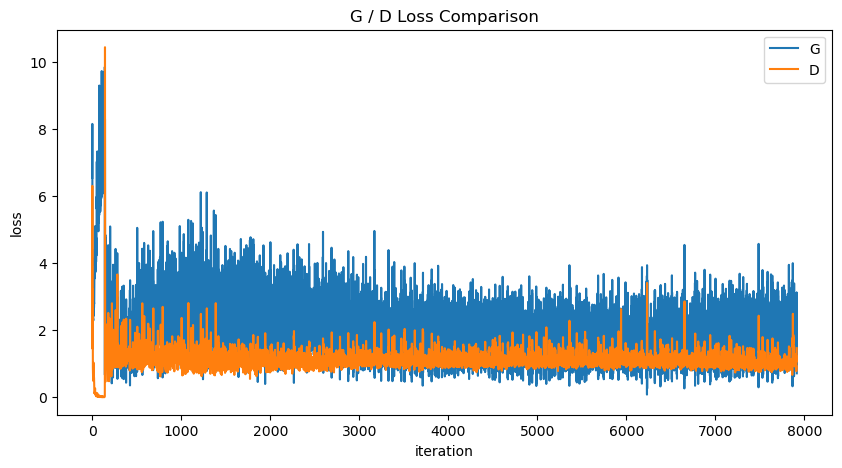

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("G / D Loss Comparison")
plt.plot(G_losses, label = "G")
plt.plot(D_losses, label = "D")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

### Progression of G

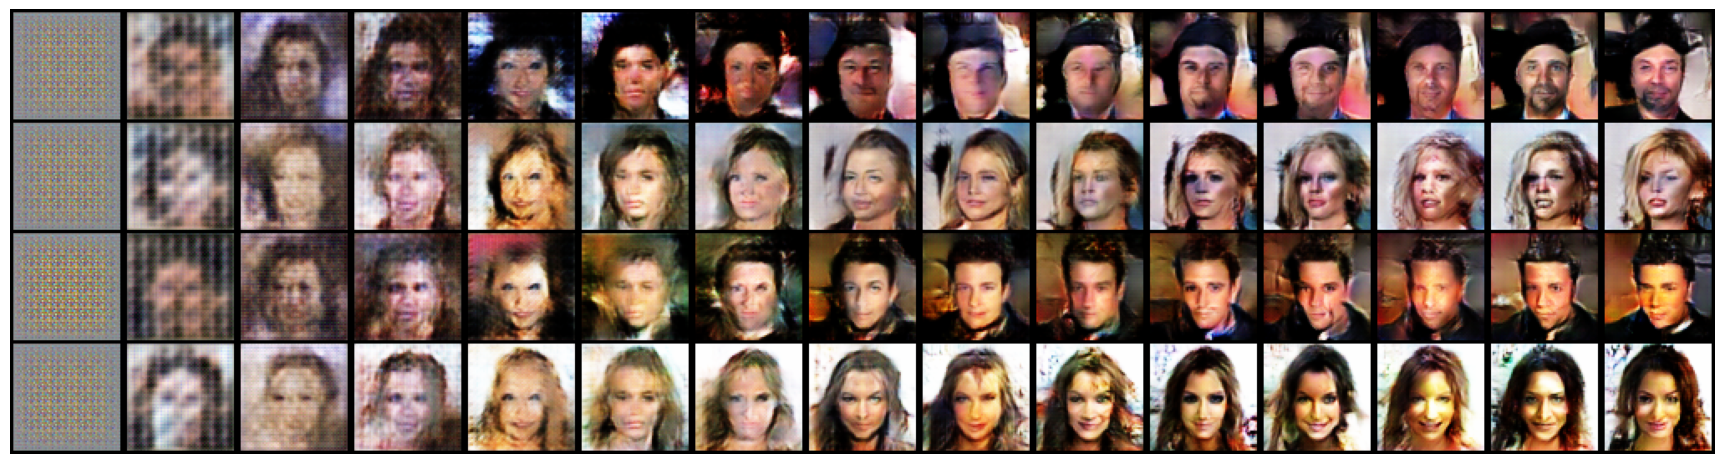

In [107]:
T = len(img_list)
pick = np.linspace(0, T-1, 15, dtype=int) 

blocks = [img_list[idx] for idx in pick]  
panel = torch.cat(blocks, dim=2)     

plt.figure(figsize=(10*2.2, 5*2.2))
plt.axis("off")
plt.imshow(panel.permute(1, 2, 0).numpy())
plt.show()

### Comparing Real and Generated Image

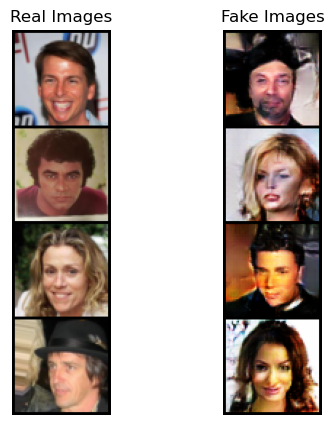

In [105]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(Device)[:4], nrow = 1 ,padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()